# Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusions](#conclusions)

<a id='intro'></a>
### Introduction

In this project the results of an A/B test run by an e-commerce website are analysed. Main goal of the project is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

The statistical methods in this project include: hypothesis testing, bootstrapping sample distribution to estimate p-values and confidence intervals and fitting the data to a logistic regression model.

<a id='probability'></a>
#### Part I - Probability
Pyton environment

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
# Setting the seed to get the same answers
np.random.seed(42)


Bad key "text.kerning_factor" on line 4 in
c:\programdata\anaconda3\envs\udacity\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv', parse_dates=['timestamp'])
df.head(2)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.value_counts(normalize=True)

0    0.880341
1    0.119659
Name: converted, dtype: float64

In [6]:
df.query('converted == 1').user_id.nunique() / df.user_id.nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

In [8]:
mask = '(group == "treatment" & landing_page != "new_page") | (group != "treatment" & landing_page == "new_page")'

(df
 .groupby(['group', 'landing_page'])
 .count()
 .reset_index().iloc[:, :3]
 .query(mask))['user_id'].sum()


3893

In [9]:
df.query(mask)

,user_id,timestamp,group,landing_page,converted
22,767017,2017-01-12 22:58:14.991443,control,new_page,0
240,733976,2017-01-11 15:11:16.407599,control,new_page,0
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0
...,...,...,...,...,...
294014,813406,2017-01-09 06:25:33.223301,treatment,old_page,0
294200,928506,2017-01-13 21:32:10.491309,control,new_page,0
294252,892498,2017-01-22 01:11:10.463211,treatment,old_page,0
294253,886135,2017-01-06 12:49:20.509403,control,new_page,0


f. Do any of the rows have missing values?

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       294478 non-null  int64         
 1   timestamp     294478 non-null  datetime64[ns]
 2   group         294478 non-null  object        
 3   landing_page  294478 non-null  object        
 4   converted     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [11]:
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == True]
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       290585 non-null  int64         
 1   timestamp     290585 non-null  datetime64[ns]
 2   group         290585 non-null  object        
 3   landing_page  290585 non-null  object        
 4   converted     290585 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 13.3+ MB


In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [13]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [14]:
df2.user_id.duplicated().sum()

1

c. What is the row information for the repeat **user_id**? 

In [15]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [16]:
df2 = df2[~df2.user_id.duplicated()]
df2.shape

(290584, 5)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
p_conv = df2.query('converted == 1').user_id.nunique() / df2.user_id.nunique()
p_conv

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
p_old_obs = df2.query('group == "control" & converted == 1').user_id.nunique() / df2.query('group == "control"').user_id.nunique()
p_old_obs

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
p_new_obs = df2.query('group == "treatment" & converted == 1').user_id.nunique() / df2.query('group == "treatment"').user_id.nunique()
p_new_obs

0.11880806551510564

d. What is the probability that an individual received the new page?

In [20]:
p_new_page = df2.query('landing_page == "new_page"').user_id.nunique() / df2.user_id.nunique()
p_new_page

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

> **There is no clear evidence.** Both groups have very similar probabilities to convert, with treatment group slightly lower probability. Further it will be investigated if the results are statistically significant. Also dataset is quite well balanced with respect to landing page distribution, there are 37 more user in the treatment group.

In [21]:
# Converted ratio for both groups
df2.groupby(['group', 'landing_page']).mean().loc[:, 'converted']

group      landing_page
control    old_page        0.120386
treatment  new_page        0.118808
Name: converted, dtype: float64

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

> **In this case, there is a question associated with a direction - so for the null the converted rate for old page is larger or equal than for the new page.  Below is one of the ways you could write the null and alternative.  Since the converted rate for new page is listed first here, the alternative would suggest that the difference is positive.**

$$H_0: p_{new} - p_{old}  \leq 0$$

$$H_1: p_{new} - p_{old} > 0$$

> $p_{old}$ and $p_{new}$ are the converted rates for the old and new page, respectively.
> Futhermore, estimated p-values from the hypothesis tests have to be lower than 0.05 ($\alpha$)
   

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [22]:
# Probability of user from treatment group to convert
# Under the null - assumed to be equal to the converted rate in dataset regardless of the page
p_new = p_conv
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [23]:
# Probability of user from control group to convert
# Under the null - assumed to be equal to the converted rate in dataset regardless of the page
p_old = p_conv
p_old

0.11959708724499628

c. What is $n_{new}$?

In [24]:
# Number of unique users in treatment group
n_new = df2.query('group == "treatment"').user_id.count()
n_new

145310

d. What is $n_{old}$?

In [25]:
# Number of unique users in control group
n_old = df2.query('group == "control"').user_id.count()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
#np.random.seed(42)
new_page_converted = np.random.choice([0,1], size=n_new, p=[1-p_new,p_new])
new_page_converted.mean()

0.11849150092904824

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
#np.random.seed(42)
old_page_converted = np.random.choice([0,1], size=n_old, p=[1-p_old,p_old])
old_page_converted.mean()

0.12088880322700551

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [28]:
new_page_converted.mean() - old_page_converted.mean()

-0.002397302297957274

#### Bootstrapping sample distribution

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [29]:
# Create a sampling distribution of the converted rate difference with bootstrapping
p_diffs = []

for _ in range(10_000):    
    # sampling converted rates for new and old page
    p_new_sample = np.random.choice([0,1], size=n_new, p=[1-p_new,p_new]).mean()
    p_old_sample = np.random.choice([0,1], size=n_old, p=[1-p_old,p_old]).mean()
    
    # sampled difference
    p_diffs.append(p_new_sample - p_old_sample)

# Convert list to numpy array
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

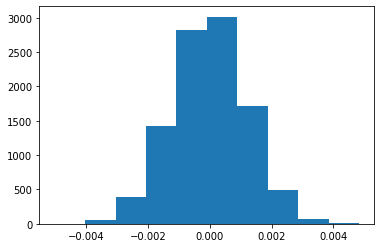

In [30]:
# Plot sampling distribution
plt.hist(p_diffs);

The obtain sample distribution from bootstrapping samples resembles normal distribution.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [31]:
# Compute the observed difference
obs_diff = p_new_obs - p_old_obs
obs_diff

-0.0015782389853555567

In [32]:
# Compute p-value
p_val = (p_diffs > obs_diff).mean()
p_val

0.901

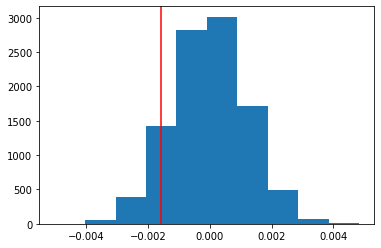

In [33]:
# Plot sampling distribution with observed difference
plt.hist(p_diffs);
plt.axvline(obs_diff, color='red');

#### Confidence intervals from bootstrapping samples
It can be seen that the observed difference from whole dataset falls in between the obtained confidence interval.

In [34]:
np.percentile(p_diffs, 2.5), np.percentile(p_diffs, 97.5)

(-0.0023557798886603737, 0.0022762881863714426)

#### P-values
k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

> **p-values** are the probability of observing your data or something more extreme in favor of the alternative given the null hypothesis is true. The p-value associated with a 95% confidence level is 0.05 (Type I error error threshold).

> In our case the p-value is higher than 0.05, therefore we fail to reject the null hypothesis. there is not enough evidence that the result is statistically significant.

> This results means that on average there would be no or equal user convertion rate for the new page compared to the convertion rate of old page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [35]:
convert_old = df2.query('landing_page == "old_page" and converted == 1').shape[0] 
convert_new = df2.query('landing_page == "new_page" and converted == 1').shape[0]
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [36]:
from statsmodels.stats.proportion import proportions_ztest

# Set null to 0 and alternative to 'larger'
zstat, pval = proportions_ztest([convert_new, convert_old], [n_new, n_old], value=0, alternative='larger')
round(zstat, 3), round(pval, 3)

(-1.311, 0.905)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

>**P-value** calculated with bootstraping sample distribution match with the built-in *proportions_ztest* method results from statsmodels package.

> **Z-score** is a test statistic for the z-test, it is a test of statistical significance that helps to decide whether or not to reject the null hypothesis. Z-scores are measures of standard deviation. The critical Z-score values for a 95% confidence level are -1.96 and +1.96 standard deviations and the p-value associated with a 95% confidence level is 0.05.

> So from the statsmodels *proportions_ztest* results we achieved a z-score of -1.311. This result can be interpreted as that the simulated converted rate difference is "-1.311 standard deviations away from the mean". As the Z-score it falls between -1.96 and +1.96 standard deviations and p-value is larger than 0.05, the null hypothesis cannot be rejected. 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be achieved by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

> **We are infering a response variable categorical variable with two labels 0 and 1 (conversion, no conversion), therefore we need to perform Logistic regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [37]:
# Add an intercept column
df2['intercept'] = 1

# Create a dummy variable for for groups
df2[['ab_page']] = pd.get_dummies(df2['group'], drop_first=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [38]:
import statsmodels.api as sm

lr_abpage = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results_abpage = lr_abpage.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [39]:
results_abpage.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 29 Apr 2020   Pseudo R-squ.:               8.077e-06
Time:                        21:25:42   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?

> **The p-value associated with ab_page** is 0.190. The p-value in the logistic regression model is from a *two-tailed test*, namely for each regression coefficient, the tested null hypothesis is that the coefficient is equal to zero, and alternative that it is not equal to 0. Whereas the test in the hypothesis testing of Part II uses a one-tailed test. Thus, to get the p-value for the one-tailed test of the variable having a coefficient greater than zero, you would need to divide the 0.190 by 2, yielding 0.095. Then subtract 0.095 from 1 in order to get a result for a one-sided test: 1 - 0.095 = 0.905. Indication that we need to subtract comes from the negative z-score and negative coefficient for ab_page variable.

> **p-value and z-score** for convertion rate match with the results using *proportions_ztest* from statsmodels package.


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

> It is advantegous to include another variables, in order to make our predictions better. Depending on what the model is used for - to estimate how the inputs are related to the response or simply to make better predictions. Furthermore, significant bi-variate relationships are not always significant in multiple regression. 

> The disadvantages could be if the variables that are not important, they could make the model more complex. To mention the problems associated with multiple linear regression, linear relationships may not exists, correlated errors, non-constant variance, outliers and multicolinearity where the input variables are not independent.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?

In [40]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [41]:
# First add all countries as dummy variables
# When fitting the logistic regression model, will use only 2 countries
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [42]:
# Fit only 2 countries (due to multicolinearity)
lr_countries = sm.Logit(df_new['converted'], df_new[['intercept', 'UK', 'US']])
results_countries = lr_countries.fit()
results_countries.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Wed, 29 Apr 2020   Pseudo R-squ.:               1.521e-05
Time:                        21:25:45   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [60]:
# Converted ratio for countries
df_new.groupby(['country', 'landing_page']).mean().loc[:, 'converted']

country  landing_page
CA       new_page        0.111902
         old_page        0.118783
UK       new_page        0.121171
         old_page        0.120022
US       new_page        0.118466
         old_page        0.120630
Name: converted, dtype: float64

Canada has the largest conversion rate difference (0.6%) betwen old and new page.

In [43]:
### Fit Your Linear Model And Obtain the Results
lr_model = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US']])
results = lr_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 29 Apr 2020   Pseudo R-squ.:               2.323e-05
Time:                        21:25:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

#### Comparing the Logistic regression models

> **Pseudo R-squared** value increased from first logistic model (with landing page as the only explanatory variable) to second to the last model with countries and landing page. This is indicating that by adding more variables the model predicts the outcome better.
> It must be mentioned that  pseudo R-squared values only have meaning when they are compared to another pseudo R-squared of the same data, predicting the same response variable. In this compariosn the higher pseudo R-squared indicates which model better predicts the outcome.

> **p-values** for all the model regression variables were higher than the 0.05 (intercept and UK the lowest). This indicates that there is insufficient evidence the data to conclude that a non-zero correlation exists. 

In [58]:
print(f'p-values (landing page):\n{results_abpage.pvalues}\n')
print(f'p-values (countries):\n{results_countries.pvalues}\n')
print(f'p-values (landing page and countries):\n{results.pvalues}')

p-values (landing page):
intercept    0.000000
ab_page      0.189886
dtype: float64

p-values (countries):
intercept    0.000000
UK           0.074047
US           0.129068
dtype: float64

p-values (landing page and countries):
intercept    0.000000
ab_page      0.191245
UK           0.074500
US           0.129501
dtype: float64


> **Regression coefficients** are changing slighlty from model to model

In [61]:
print(f'Coefficients (landing page):\n{results_abpage.params}\n')
print(f'Coefficients (countries):\n{results_countries.params}\n')
print(f'Coefficients (landing page and countries):\n{results.params}')

Coefficients (landing page):
intercept   -1.988777
ab_page     -0.014989
dtype: float64

Coefficients (countries):
intercept   -2.037532
UK           0.050719
US           0.040803
dtype: float64

Coefficients (landing page and countries):
intercept   -2.030029
ab_page     -0.014943
UK           0.050640
US           0.040757
dtype: float64


### Length of the A/B test

In [45]:
df2.timestamp.max() - df2.timestamp.min() 

Timedelta('21 days 23:59:49.081927')

<a id='conclusions'></a>
### Conclusions

> In this project the results of an A/B test run by an e-commerce website were analysed. Main goal of the project was to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.
> By performing the hypothesis testing, the conclusion was that theres is not enough statistical evidence that the new webpage design would lead to a higher user converted rates than the current webpage version. It may be considered to run the experiment longer, as the current A/B test results were run only for 21 days. 

> **p-value and z-score** values for convertion ratio match with the results obtaine from bootstrapping sample distribution with results from using *proportions_ztest* method from statsmodels, as well as with the values obtained from logistic regression fitting to the dataset.

#### Part I - Probability

> Firstly, general characteristics of the dataset were investigated, and duplicate and not matching values were removed. The observed converted rate for both groups was around 12% with very very slight difference. The treatment and control group sizes were of a similar size.

#### Part II - A/B Test

> In this project A/B hypothesis testing is performed based on the data of the converted rates for new and old page design. Statistical significance (p-values, z-scores) of the A/B test results are determined using 3 different methods that are shortly described further.

> By means of bootstrapping the original dataset was resampled 10 000 in order to create many simulated samples. Thus the average converted rates were retrieved and the simulated differences between the new webpage and old webpage design groups were calculated. Further using this bootstrapping sample distribution, the p-value and confidence interval was estimated.

> Results from Hypothesis testing by bootsrapping and comparison with z-test results from statsmodels package provided almost the same p-values (0.905) score. Both test showed that the A/B test results did not have enough evidence that the new page design would lead to better conversion rates, therefore we failed to reject the null hypothesis.

#### Part III - Regression

> Logistic regression was performed on the dataset because the response variable is a categorical variable with two states: convertion or no convertion. Now p-values and z-scores were obtained by fitting the dateset to logistic regession model with landing page as the input variable and converted as the target varaiable. The results of p-values and z-scores  matched with

> Additionally, in this part the dataset was expanded by including the countries from where the test participant are from, to investigate if this has additional impact on the converted rate. P-values of the additional parameters were higher than 0.05 The pseudo R-squared values increased by adding more explanatory variables to the model, indicating that the model fit improved.

#### Limitiations
#### Fit the model with the logistic regression from scikit-learn
In general, the model seems to predict all the values to be 0, but it still would give 88% accuracy score. This is due to the fact that the dataset is imbalanced with respect to converted column.

In [46]:
from sklearn.model_selection import train_test_split

# 80% training set, 20% validation set
X, y = df_new[['intercept', 'ab_page', 'UK', 'US']].values, df_new['converted'].values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [48]:
model.score(X_train, y_train), model.intercept_, model.coef_ 

(0.8805636929112519,
 array([-1.01532174]),
 array([[-1.01264089, -0.00835172,  0.04372339,  0.03347125]]))

In [49]:
model.score(X_valid, y_valid), model.intercept_, model.coef_ 

(0.8797597948965019,
 array([-1.01532174]),
 array([[-1.01264089, -0.00835172,  0.04372339,  0.03347125]]))

In [50]:
model.predict(X_valid).mean()

0.0